In [1]:
from itertools import product
from os import path

import matplotlib.pyplot as plt
import pandas as pd


In [2]:
results = pd.read_csv('data/results-all.csv')

algs = results.columns[5:]
noise_distributions = results.noise_distribution.unique()
k_vals = results.k.unique()
m_vals = results.m.unique()
slopes = results.slope.unique()

In [3]:
abs_suffix = '_abs'
squared_suffix = '_squared'

for alg in algs:
    results[alg + abs_suffix] = results[alg].abs()
    results[alg + squared_suffix] = results[alg].pow(2)

In [4]:
groups = results.groupby(['noise_distribution', 'slope', 'm', 'k'])

def fixed_sem(series):
    return series.sem()

means = groups.mean().reset_index()
# For some reason groups.sem() causes an error
errors = groups.agg(fixed_sem).reset_index()

In [10]:
noise_display = {
    'normal(0,.5^2)': r'$\mathcal{N}(0, .5^2)$',
    'uniform(-2,2)': r'$\mathcal{U}(-2, 2)$',
    'beta(2,2)-mirrored': r'$\beta(2, 2)$',
    'power-law(2)-mirrored': r'$PL(2)$',
}

alg_display = {
    'all': 'All',
    'partition': r'$F^{min}$',
    'opt': r'$F^{opt}$',
    'random_1': 'Random 1',
    'random_1000': 'Random 1000',
    'random_(10*km)': 'Random 10km'
}

In [13]:
def create_plot(square, noise_dist, slope, m, file_name = None):
    plt.clf()
    if square:
        suffix = squared_suffix
        ylabel = 'Mean squared bias'
    else:
        suffix = abs_suffix
        ylabel = 'Mean bias'

    means_filtered = means[(means.noise_distribution == noise_dist)
                                & (means.slope == slope)
                                & (means.m == m)]
    errors_filtered = errors[(errors.noise_distribution == noise_dist)
                                & (errors.slope == slope)
                                & (errors.m == m)]


    x_vals = [str(i) for i in k_vals]

    for alg in algs:
        y_vals = means_filtered[alg + suffix]
        alg_errors = errors_filtered[alg + suffix]
        if y_vals.isnull().all():
            continue
        plt.errorbar(x_vals, y_vals, yerr=alg_errors, marker = "s", label=alg_display[alg], capsize=4)

    plt.xlabel("K value")
    plt.ylabel(ylabel)

    plt.title(fr'noise={noise_display[noise_dist]}, m={m}, $\beta_1$={slope}')

    plt.legend(bbox_to_anchor=(1, 1))

    plt.yscale('log')
    if file_name is None:
        plt.show()
    else:
        file_path = path.join('plots', file_name)
        plt.savefig(file_path, bbox_inches = 'tight', format='pdf')
        plt.close()


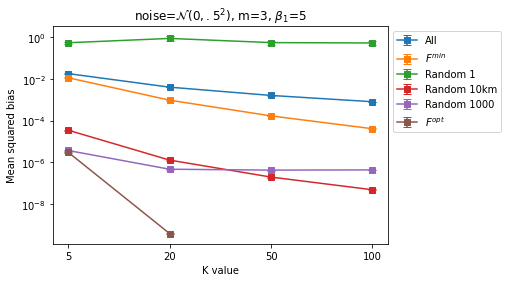

In [14]:
create_plot(True, noise_distributions[1], 5, 3)

In [15]:
for square, noise_dist, slope, m in product([True], noise_distributions[:-1], slopes, m_vals):
    file_name = f'{"square" if square else "abs"}-noise={noise_dist[:noise_dist.index("(")]}-m={m}-slope={slope}.pdf'
    create_plot(square, noise_dist, slope, m, file_name)
